In [1]:
import math
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
from matplotlib import figure

In [2]:
def Q_air_heating(G, t1, t2):
  # G м3/ч 
  # Q_air_heating кВт
  return round(0.278 * 1.21 * 1.005 * G * (t1-t2) / 1000, 0)


def G_air_heating(Q, t1, t2):
  # G м3/ч 
  # Q_air_heating кВт
  return int ((Q * 1000) / (0.278 * 1.21 * 1.005 * (t1-t2)) if t1 != t2 else 0)


def plot_df(df: pd.DataFrame, y_column, xtick_step, title='заголовок', value='показатель'):

    plt.figure(figsize=(24, 12), dpi=80)

    fig, ax1 = plt.subplots(1, figsize=(24,12))
    
    ax1.plot(df.index, df[y_column])
    ax1.set_xticks(df.index[::xtick_step])
    ax1.set_xticklabels(df.index[::xtick_step], rotation=90)

    plt.title(f"{title}")
    plt.xlabel('День')
    plt.ylabel(value)
    plt.grid(True)
    plt.legend()
    plt.show()

    # plt.savefig(name_output)
    # plt.close(fig)

In [3]:
df = pd.read_csv('weather_historicat_prepared.csv', index_col=['Time'])

In [4]:
df

,T,day,month,year,hour
Time,,,,,
02.05.2024_12:00,9.2,2,5,2024,12:00
02.05.2024_09:00,8.1,2,5,2024,09:00
02.05.2024_06:00,7.0,2,5,2024,06:00
02.05.2024_03:00,8.6,2,5,2024,03:00
02.05.2024_00:00,11.5,2,5,2024,00:00
...,...,...,...,...,...
02.05.2005_12:00,7.0,2,5,2005,12:00
02.05.2005_09:00,7.4,2,5,2005,09:00
02.05.2005_06:00,6.4,2,5,2005,06:00


In [5]:
#считаем что модуль мощностью 1.65 МВт 
Q_it = 1650

#считаем что расход воздуха через стойки постоянный 
# с разницей температур 7гр
t_hot_corridor_max = 35
t_cold_corridor_max = 28
delta_t = t_hot_corridor_max - t_cold_corridor_max
hours_step = 3

G_it = G_air_heating(Q_it, t_hot_corridor_max, t_cold_corridor_max)

fun_G_m3_h_intake = 19000
fun_number_intake = G_it // fun_G_m3_h_intake
fun_kW_e_intake = 6 

fun_G_m3_h_exhaust = 19000
fun_number_exhaust = G_it // fun_G_m3_h_exhaust
fun_kW_e_exhaust = 6 



cooling_temp_needs = []

df['G_intake'] = df['T'].map(lambda x: abs(G_air_heating(Q_it, t_hot_corridor_max, x)) if abs(x - t_hot_corridor_max) > delta_t else G_it)


df['G_recircle'] = G_it - df['G_intake']
df['G_full'] = G_it
df['G_%'] = 100* df['G_recircle'] / df['G_full'] 


for index, row in df.iterrows():
    cooling_temp_needs.append(round(t_hot_corridor_max - row['T'] - delta_t, 2)) if row['G_recircle'] == 0 else cooling_temp_needs.append(0)

df['cooling_needs_temp'] = cooling_temp_needs
df['cooling_kW*h'] = df['cooling_needs_temp'].map(lambda x: abs(hours_step * 0.278 * 1.21 * 1.005 * G_it * (x) / 1000))

df['IT_consume_kW*h'] = hours_step * Q_it

df['fan_in_kW*h'] = hours_step * fun_number_intake * fun_kW_e_intake # поддерживаем расход равный расходу вентиляторов в стойках 
df['fan_out_kW*h'] = df['G_intake'].map(lambda x: (math.ceil(x / fun_G_m3_h_exhaust) * fun_kW_e_exhaust * hours_step))  # расход выбрасываемого воздуха равен приточному уличному

df['PUE_cooling'] = (df['fan_out_kW*h'] + df['fan_in_kW*h'] + df['cooling_kW*h'] + df['IT_consume_kW*h']) / df['IT_consume_kW*h']

In [6]:
df.loc[df['PUE_cooling'] > 1.2]

,T,day,month,year,hour,G_intake,G_recircle,G_full,G_%,cooling_needs_temp,cooling_kW*h,IT_consume_kW*h,fan_in_kW*h,fan_out_kW*h,PUE_cooling
Time,,,,,,,,,,,,,,,
30.04.2024_18:00,21.8,30,4,2024,18:00,369754,327497,697251,46.969743,0.0,0.0,4950,648,360,1.203636
30.04.2024_15:00,22.4,30,4,2024,15:00,387362,309889,697251,44.444397,0.0,0.0,4950,648,378,1.207273
26.04.2024_12:00,21.5,26,4,2024,12:00,361537,335714,697251,48.148228,0.0,0.0,4950,648,360,1.203636
02.04.2024_18:00,22.4,2,4,2024,18:00,387362,309889,697251,44.444397,0.0,0.0,4950,648,378,1.207273
02.04.2024_15:00,22.6,2,4,2024,15:00,393609,303642,697251,43.548450,0.0,0.0,4950,648,378,1.207273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18.05.2005_18:00,22.9,18,5,2005,18:00,403368,293883,697251,42.148810,0.0,0.0,4950,648,396,1.210909
18.05.2005_15:00,23.1,18,5,2005,15:00,410148,287103,697251,41.176420,0.0,0.0,4950,648,396,1.210909
18.05.2005_12:00,23.0,18,5,2005,12:00,406730,290521,697251,41.666631,0.0,0.0,4950,648,396,1.210909


In [7]:
df.describe()

,T,day,month,year,G_intake,G_recircle,G_full,G_%,cooling_needs_temp,cooling_kW*h,IT_consume_kW*h,fan_in_kW*h,fan_out_kW*h,PUE_cooling
count,64838.000000,64845.000000,64845.000000,64845.000000,64845.000000,64845.000000,64845.0,64845.000000,64838.000000,64838.000000,64845.0,64845.0,64845.000000,64838.000000
mean,6.760713,15.728121,6.441591,2014.337034,209452.331236,487798.668764,697251.0,69.960268,-0.025248,17.853596,4950.0,648.0,207.344622,1.176394
std,10.767111,8.805758,3.468182,5.080693,113075.727630,113075.727630,0.0,16.217363,0.297440,210.332397,0.0,0.0,107.108299,0.054234
min,-30.500000,1.000000,1.000000,2005.000000,74515.000000,0.000000,697251.0,0.000000,-9.800000,0.000000,4950.0,648.0,72.000000,1.145455
25%,-0.700000,8.000000,3.000000,2010.000000,136716.000000,450748.000000,697251.0,64.646447,0.000000,0.000000,4950.0,648.0,144.000000,1.160000
50%,6.200000,16.000000,6.000000,2014.000000,169470.000000,527781.000000,697251.0,75.694549,0.000000,0.000000,4950.0,648.0,162.000000,1.163636
75%,15.200000,23.000000,9.000000,2018.000000,246503.000000,560535.000000,697251.0,80.392140,0.000000,0.000000,4950.0,648.0,234.000000,1.178182
max,37.800000,31.000000,12.000000,2024.000000,697251.000000,622736.000000,697251.0,89.313031,0.000000,6929.991536,4950.0,648.0,666.000000,2.665453


In [8]:
sum(df['cooling_kW*h'])

nan

In [9]:
df.loc[df['PUE_cooling'] > 1.2].count()

T                     5663
day                   5663
month                 5663
year                  5663
hour                  5663
G_intake              5663
G_recircle            5663
G_full                5663
G_%                   5663
cooling_needs_temp    5663
cooling_kW*h          5663
IT_consume_kW*h       5663
fan_in_kW*h           5663
fan_out_kW*h          5663
PUE_cooling           5663
dtype: int64

In [10]:
sum(df['cooling_kW*h']) 

nan

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1920x960 with 0 Axes>

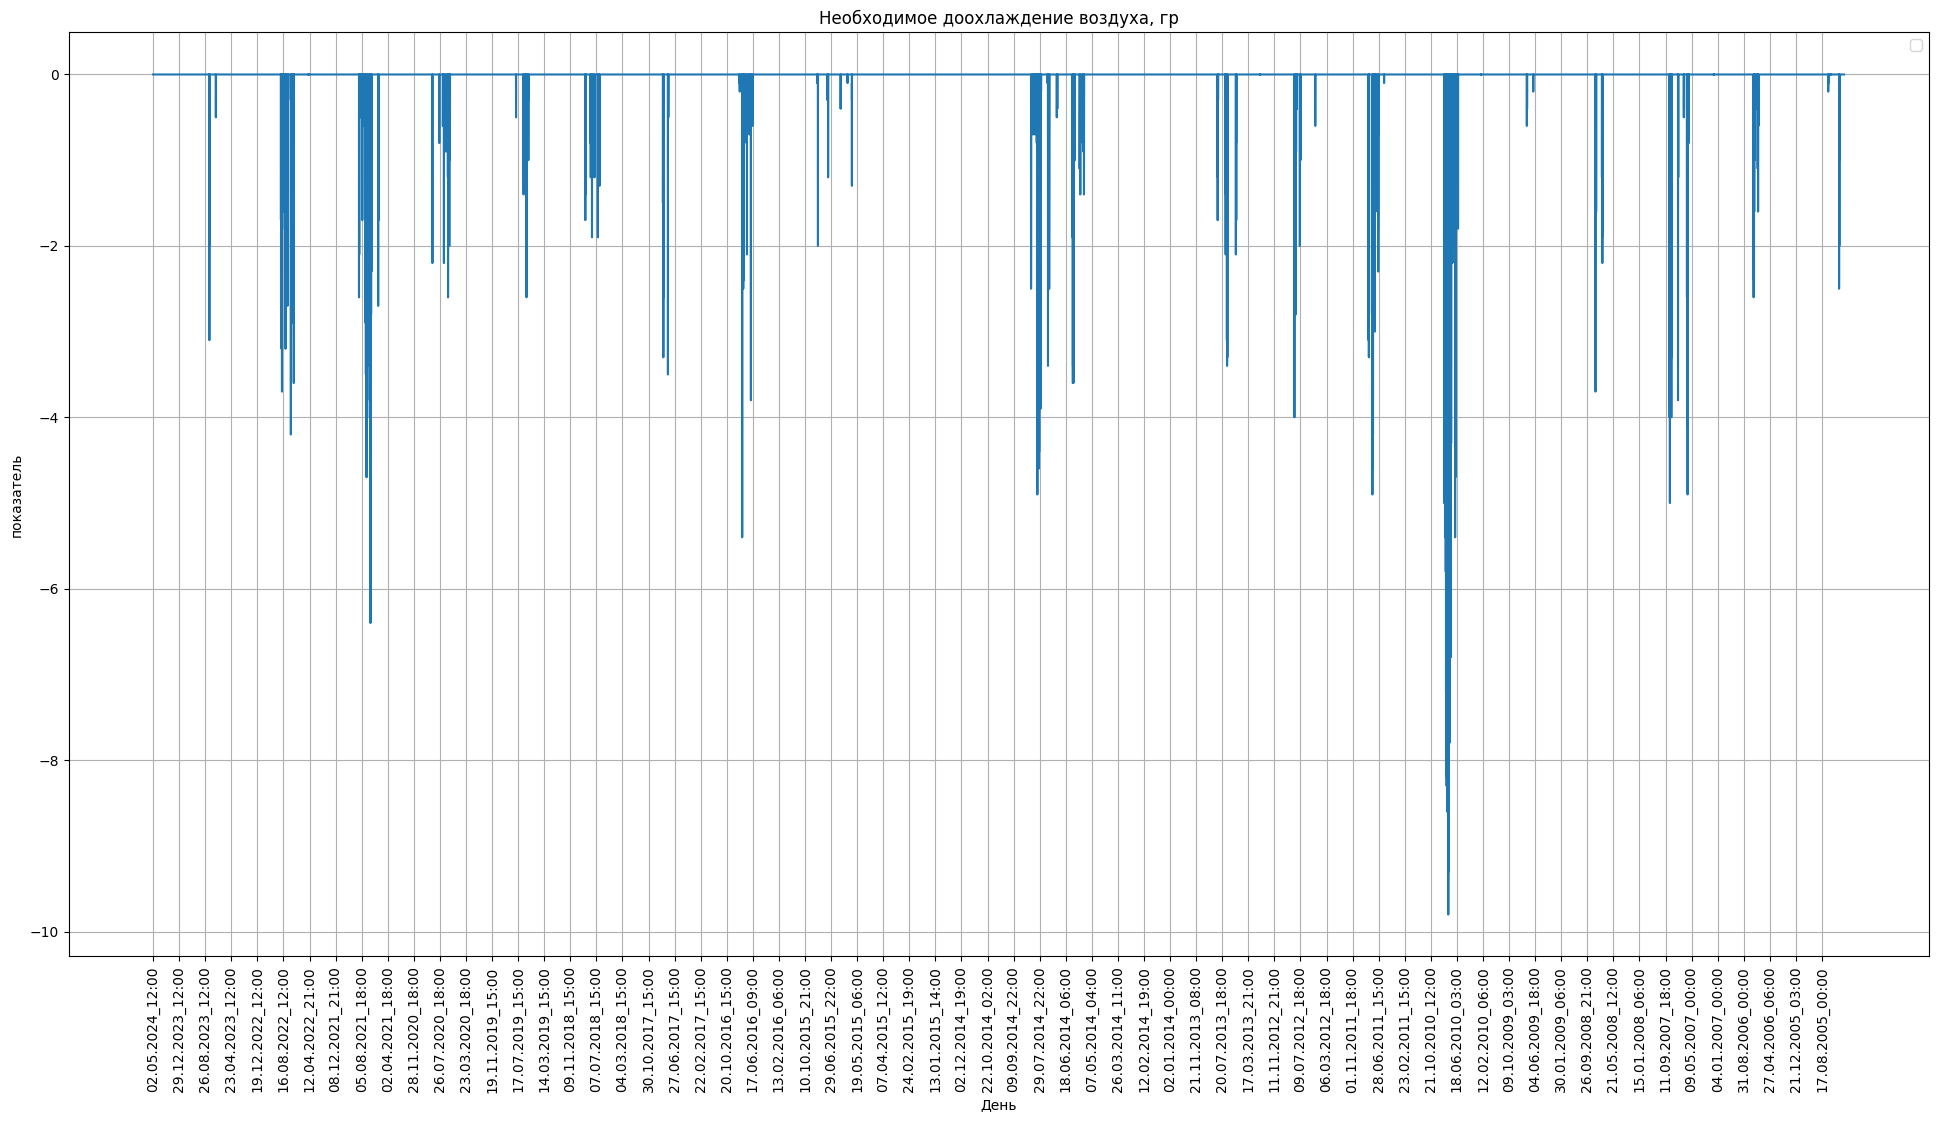

In [11]:
plot_df(df, 'cooling_needs_temp', 1000, 'Необходимое доохлаждение воздуха, гр')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1920x960 with 0 Axes>

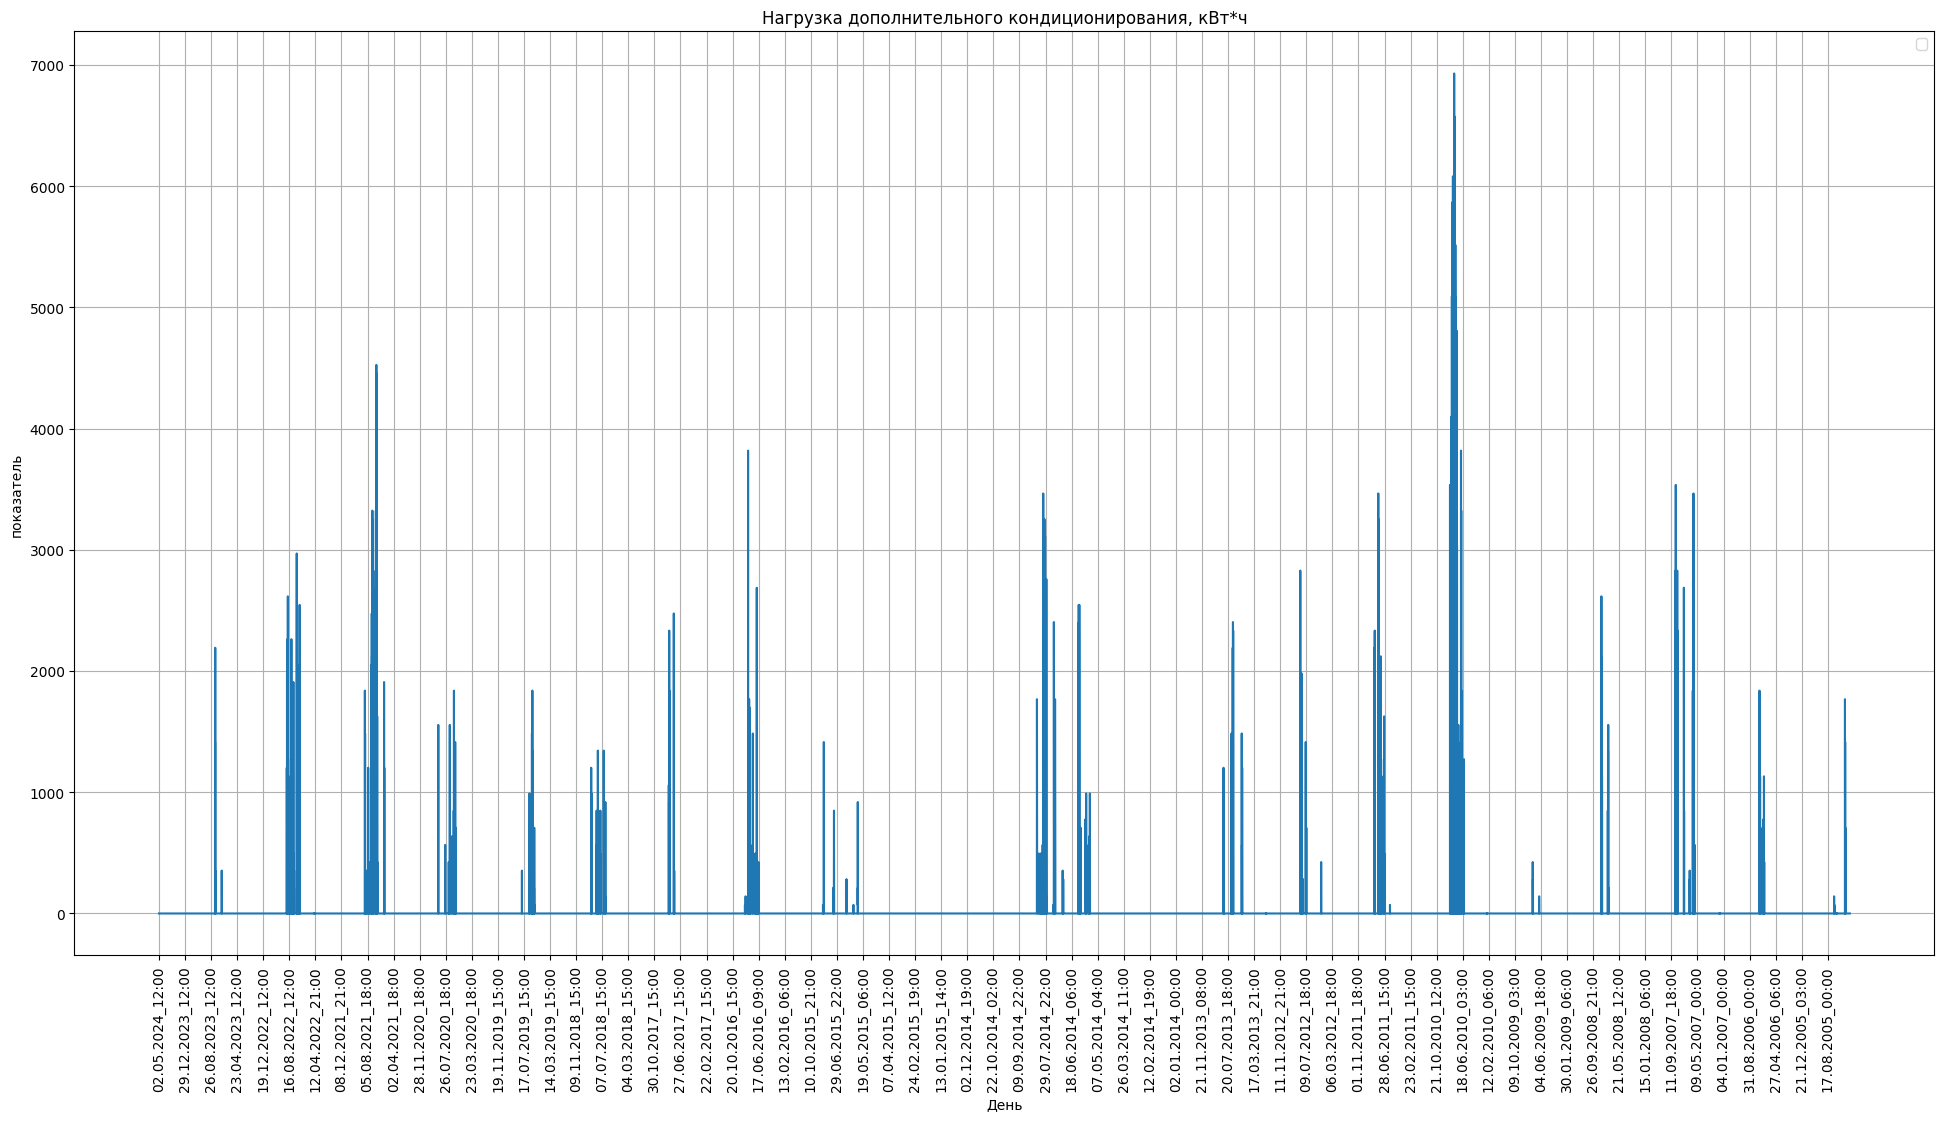

In [12]:
plot_df(df, 'cooling_kW*h', 1000,  'Нагрузка дополнительного кондиционирования, кВт*ч')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1920x960 with 0 Axes>

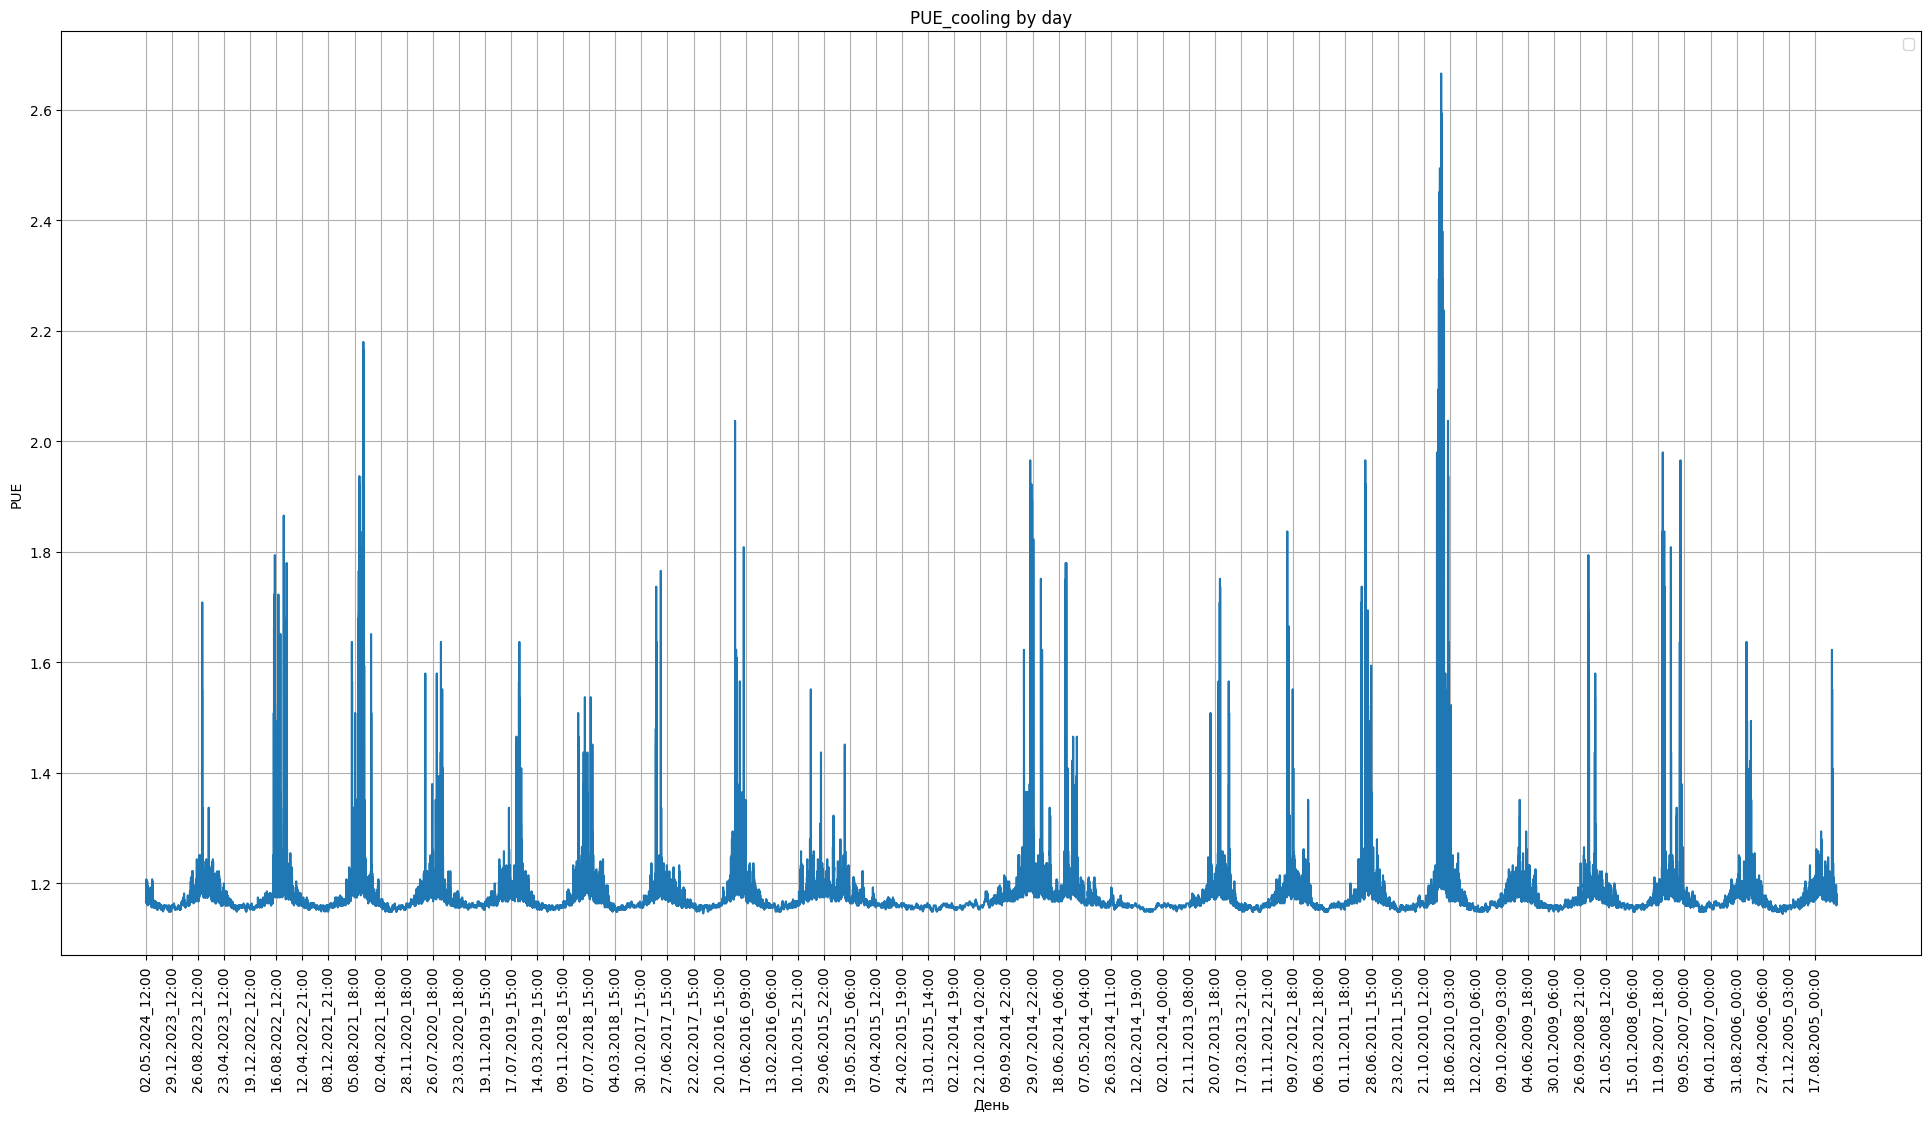

In [13]:
plot_df(df,'PUE_cooling', 1000, 'PUE_cooling by day', 'PUE')

In [14]:
print(f"min PUE_cooling - {df['PUE_cooling'].min()}" )
print(f"mean PUE_cooling - {df['PUE_cooling'].mean()}" )
print(f"max PUE_cooling - {df['PUE_cooling'].max()}" )
print(f"variance PUE_cooling - {df['PUE_cooling'].var()}" )
print(f"std PUE_cooling - {df['PUE_cooling'].std()}" )

min PUE_cooling - 1.1454545454545455
mean PUE_cooling - 1.1763936768698022
max PUE_cooling - 2.6654528356373457
variance PUE_cooling - 0.00294132213167316
std PUE_cooling - 0.054233957366885556


In [15]:
print(f" PUE < 1.2 --- {len(df.loc[df['PUE_cooling'] < 1.2]) / len(df.loc[df['PUE_cooling'] > 1.0]) * 100} %")
print(f" PUE < 1.4 --- {len(df.loc[df['PUE_cooling'] < 1.4]) / len(df.loc[df['PUE_cooling'] > 1.0]) * 100} %")

 PUE < 1.2 --- 89.81153027545575 %
 PUE < 1.4 --- 99.19337425583763 %


In [21]:
print(f"Мощность системы охлаждения одного блока по quantile(0.95) значению - { int(df.loc[df['cooling_kW*h'] > 0.0]['cooling_kW*h'].quantile(0.95) / hours_step)} кВт" )
print(f"Мощность системы охлаждения одного блока по quantile(0.99) значению - { int(df.loc[df['cooling_kW*h'] > 0.0]['cooling_kW*h'].quantile(0.99) / hours_step)} кВт" )
print(f"Мощность системы охлаждения одного блока по max значению - {int(df['cooling_kW*h'].max() / hours_step)} кВт" )

Мощность системы охлаждения одного блока по quantile(0.95) значению - 1268 кВт
Мощность системы охлаждения одного блока по quantile(0.99) значению - 1838 кВт
Мощность системы охлаждения одного блока по max значению - 2309 кВт
